In [1]:
from prettyfigure.style import *

%matplotlib inline
from colossus.Cosmology import *
from colossus.HaloConcentration import *
from colossus.HaloDensityProfile import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

import cosmolopy as cp

from dmb.single_halo import *
from dmb.mass_func import *

define_figure_style()
setCosmology('planck15')
cosmo = getCurrent()

params = {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}

dm_data_pos = np.genfromtxt('PPPC4DM/AtProduction_positrons.dat', names=True)
dm_data_neutr_e = np.genfromtxt('PPPC4DM/AtProduction_neutrinos_e.dat', names=True)
dm_data_neutr_mu = np.genfromtxt('PPPC4DM/AtProduction_neutrinos_mu.dat', names=True)
dm_data_neutr_tau = np.genfromtxt('PPPC4DM/AtProduction_neutrinos_tau.dat', names=True)
dm_data_gammas = np.genfromtxt('PPPC4DM/AtProduction_gammas.dat', names=True)
dm_data_antiprot = np.genfromtxt('PPPC4DM/AtProduction_antiprotons.dat', names=True)
dm_data_antideu = np.genfromtxt('PPPC4DM/AtProduction_antideuterons.dat', names=True)
def get_electron_spec(e=5):
    '''
    Returns the electron energy specrum 
    '''
    return 10**dm_data_pos['Log10x'][dm_data_pos['mDM']==e], \
            [dm_data_pos[dm_data_pos['mDM']==e], \
            dm_data_neutr_e[dm_data_neutr_e['mDM']==e], \
            dm_data_neutr_mu[dm_data_neutr_mu['mDM']==e],\
            dm_data_neutr_tau[dm_data_neutr_tau['mDM']==e],\
            dm_data_gammas[dm_data_gammas['mDM']==e],\
            dm_data_antiprot[dm_data_antiprot['mDM']==e],\
            dm_data_antideu[dm_data_antideu['mDM']==e]]

In [2]:
def CLfit(z, params):
    popt = [0,0,0,0]
    # Pessimistic
    if params == {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.08, 'cosmo': cosmo, 'subhalos': False}:
        popt = [  1.84649743e+04,  -1.02753619e+00,   2.46528943e+01,   1.82809696e+00]
    # Realistic
    if params == {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}:
        popt = [  4.54957836e+04,  -1.18439346e+00,   2.83227492e+01,   1.76984018e+00]
    # Optimistic
    if params == {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.24, 'cosmo': cosmo, 'subhalos': True}:
        popt = [  2.05248493e+06,  -1.41667156e+00,   4.17925455e+01,   2.09477611e+00]
    # No sub-halo
    if params == {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}:
        popt = [  3.29365151e+04,  -1.11127683e+00,   2.91912178e+01,   1.82020814e+00]
    # With mNFW
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}:
        popt = [  5.59555238e+05,  -1.30461364e+00,   3.88430632e+01,   2.21880041e+00]    
    # Vary Mcrit
    if params == {'logMcrit': -12, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}:
        popt = [  6.59796852e+04,  -1.22289653e+00,   3.12134666e+01,   1.67865004e+00]
    if params == {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}:
        popt = [  3.00818166e+04,  -1.12075206e+00,   2.39200911e+01,   1.76339590e+00]
    a, b, c, d = popt
    return a * (z)**b * np.exp(-((1+z)/c)**d) + 1

In [3]:
# z_list = np.logspace(0, np.log10(3000), 100)[::-1]
# age_list = cp.distance.age(z_list, **cp.fidcosmo)

# rho_eff = (1.0+z_list)**3 * np.sqrt(CLfit(z_list, params))*n_dm*mx
# plt.plot(z_list[:], rho_eff)
# plt.plot(z_list[:], (1+z_list)**3*n_dm*mx)
# plt.xscale('log')
# plt.yscale('log')

In [4]:
# An_rate = rho_eff**2/mx**2/2*sigmav

# Re_rate = (1.0+z_list)**6*n_b**2*3e-13

# ion_per_ann = mx*1e9*0.3/13.6

# plt.plot(z_list, (Re_rate/(An_rate*ion_per_ann))**-0.5)
# # plt.plot(z_list, Re_rate)
# plt.xscale('log')
# plt.yscale('log')

0.058817941465


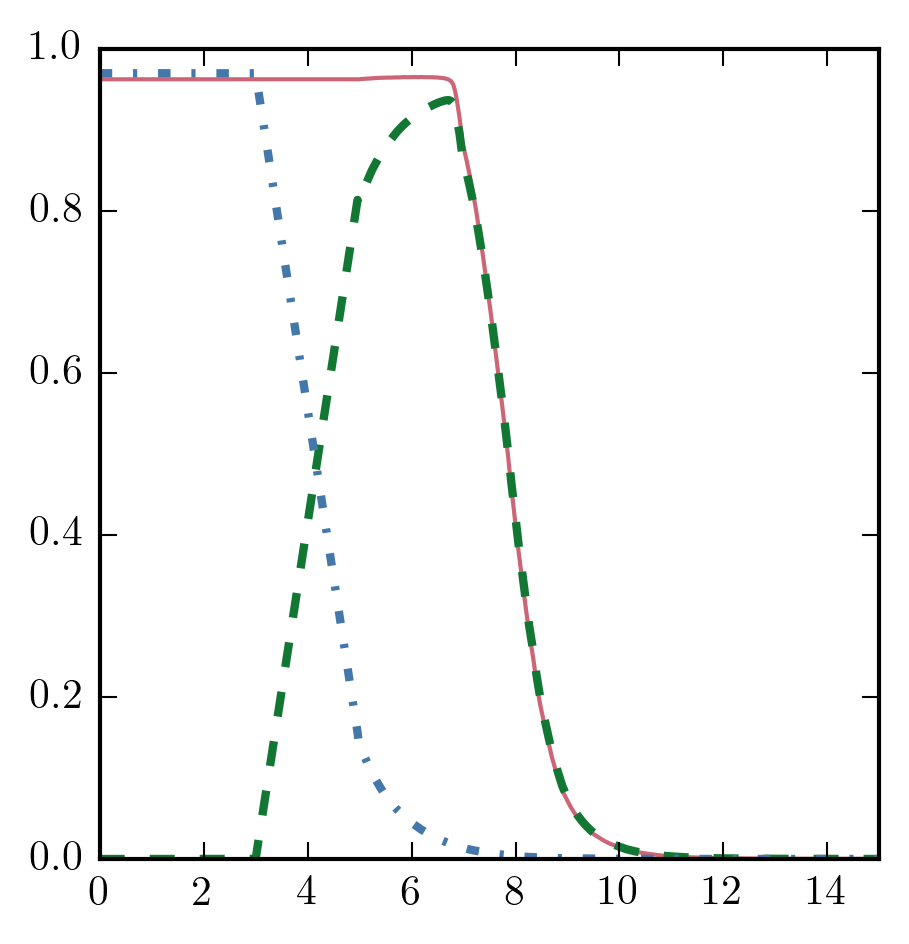

In [5]:
adata = np.loadtxt('N20/A.txt', comments='#')
# bdata = np.loadtxt('N20/B.txt', comments='#')

z_list_model = np.linspace(0, 200, 10000)
x_HII_list = np.interp(z_list_model, 1./adata[::-1,0]-1.0, adata[::-1,9])
x_HeII_list = np.interp(z_list_model, 1./adata[::-1,0]-1.0, adata[::-1,11], left = 0)
x_HeIII_list = np.interp(z_list_model, 1./adata[::-1,0]-1.0, adata[::-1,12], left = 0)

x_HeIII_list[:249] = np.interp(z_list_model[:249],[0.0, 3.0, 5.0],[0.97,0.97,0.14])
x_HeII_list[:249] = 0.97-x_HeIII_list[:249]

plt.plot(z_list_model, x_HII_list,'-',lw=1)
plt.plot(z_list_model, x_HeII_list,'--')
plt.plot(z_list_model, x_HeIII_list,'-.')
# plt.xscale('log')
# plt.yscale('log')
plt.ylim([1e-4,1])
plt.xlim([0,15])

# print cp.cr.integrate_optical_depth(np.array([1.0, 1.0]), 2.0*np.array([1.0, 1.0]), np.array([0.0, 5.0]), **cp.fidcosmo)[-1]

print cp.cr.integrate_optical_depth(x_HII_list, x_HeII_list+2.0*x_HeIII_list, z_list_model, **cp.fidcosmo)[-1]

In [6]:
import radiator
from radiator.crosssections import *
cs = cross_sections(cs={'photion': 'VFKY1996', 'collion': 'AR', 'collex': 'SKD'})

In [7]:
# cosmo = Cosmology.setCosmology('planck13')
sigmaT = 6.6524e-25 #cm^2
me = 9.109e-28 # g
c = 2.9979e10 # cm/s
hbar = 1.0545e-27 # erg*s
kB = 1.380648e-16 # erg/K


In [8]:
z = z_list[0]
T_CMB = 2.7*(1+z)
CMBphotons = 8*np.pi*2*np.pi*hbar*nu_list**3/c**3/(np.exp(2.0*np.pi*hbar*nu_list/kB/T_CMB)-1.0)/Eg_list/(hbar*2*np.pi)
print 'number of photons per cm^3: ', np.trapz(CMBphotons, Eg_list)

NameError: name 'z_list' is not defined

In [9]:
# Mass of dm particle in GeV
mx = 100
sigmav = 1e-26
channel = 'b'

Eg_list = 10**np.arange(1,np.log10(mx*1e9),0.014)/6.24e11
nu_list = Eg_list / (hbar*2*np.pi)
EgeV_list = Eg_list*6.24e11

def ICon30CMB(EgeV_list, E0, z):
    return (1+z)**-0.5 * 3.8e-1 * (EgeV_list/1e9)**0.5 * \
           np.exp(\
               -(EgeV_list/1e9)*2.4e3* \
               (1.3e9/E0)**2. / \
               ((1.+z)/61)**1. \
               )

import cosmolopy as cp

# Mass of 1 GeV
g_in_GeV = 1.782e-24 

n_dm = AST_rho_crit_0_kpc3*cosmo.Om0/AST_kpc**3*AST_Msun*cosmo.h**2/mx/g_in_GeV
n_b = AST_rho_crit_0_kpc3*cosmo.Ob0/AST_kpc**3*AST_Msun*cosmo.h**2/1.672e-24
# 
print 'Number density of DM particles in a cm^3: ', n_dm
print '"Number density" of baryons in a cm^3:    ', n_b
x, y = get_electron_spec(e=mx)
# plt.plot(x, y)
# plt.yscale('log')
# plt.xscale('log')
print np.trapz(10**x*(y[0][channel]*2), x)/2.
print np.trapz(10**x*(y[0][channel]*2)*mx, x)/(2*mx)
print np.trapz((y[0][channel]*2)*10**x*mx*np.gradient(x))/(2*mx)

e_add = np.interp(EgeV_list, 10**x*mx*1e9, y[0][channel]*2*np.gradient(x)/np.gradient(10**x), left=0, right=0)
e_add = e_add*np.gradient(EgeV_list)/1e9/mx

ph_add = np.interp(EgeV_list, 10**x*mx*1e9, y[4][channel]*np.gradient(x)/np.gradient(10**x), left=0, right=0)
ph_add = ph_add*np.gradient(EgeV_list)/1e9/mx

# print np.trapz(ph_add*EgeV_list)/1e9/2/mx

# ph_add = e_add*0.0
for i in range(len(e_add)):
    ph_add += e_add[i] * ICon30CMB(EgeV_list, EgeV_list[i], 40.0) * np.gradient(Eg_list) / Eg_list**2

    
print np.trapz(e_add*EgeV_list)/1e9/2/mx
print np.trapz(ph_add*EgeV_list)/1e9/2/mx

plt.plot(EgeV_list, e_add)
plt.plot(EgeV_list, ph_add)
plt.yscale('log')
plt.xscale('log')


Number density of DM particles in a cm^3:  1.49418490335e-08
"Number density" of baryons in a cm^3:     2.5054984114e-07
0.500970558808
0.500970558808
0.500970558808
0.0
0.0


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [12]:
def evolve_phot(mx, sigmav, channel, quite=True):
    Eg_list = 10**np.arange(np.log10(13.6),np.log10(mx*1e9),0.014)/6.24e11
    nu_list = Eg_list / (hbar*2*np.pi)
    EgeV_list = Eg_list*6.24e11
    z_start = 200.0
    z_step = 0.01
    z_list = np.array([0])
    f = (Eg_list[1]/Eg_list[0])**1
    double_shift = int(np.ceil(np.log(2.0)/np.log(f)))
    for i in range(1000):
        z_list = np.append(z_list, f*(1.+z_list[-1])-1.0)
    z_list = z_list[z_list <= z_start]
    z_list = z_list[::-4]
    boost = CLfit(z_list, params)
    photon_history = np.zeros([len(EgeV_list), len(z_list)])

    age_list = cp.distance.age(z_list,**cp.fidcosmo)
    # DM things
    n_dm = AST_rho_crit_0_kpc3*cosmo.Om0/AST_kpc**3*AST_Msun*cosmo.h**2/mx/g_in_GeV
    n_b = AST_rho_crit_0_kpc3*cosmo.Ob0/AST_kpc**3*AST_Msun*cosmo.h**2/1.672e-24
    # 
    if not quite:
        print 'Number density of DM particles in a cm^3: ', n_dm
        print '"Number density" of baryons in a cm^3:    ', n_b

    # Contribution from one DM+DM annihilation
    x, y = get_electron_spec(e=mx)
#     print np.trapz(10**x*(y[0][channel]*2), x)/2.
#     print np.trapz(10**x*(y[0][channel]*2)*mx, x)/(2*mx)
#     print np.trapz((y[0][channel]*2)*10**x*mx*np.gradient(x))/(2*mx)
    e_add = np.interp(EgeV_list, 10**x*mx*1e9, y[0][channel]*2*np.gradient(x)/np.gradient(10**x), left=0, right=0)
    e_add = e_add*np.gradient(EgeV_list)/1e9/mx
    ph_add = np.interp(EgeV_list, 10**x*mx*1e9, y[4][channel]*np.gradient(x)/np.gradient(10**x), left=0, right=0)
    ph_add = ph_add*np.gradient(EgeV_list)/1e9/mx
    x, y = get_electron_spec(e=mx)
    e_add = np.interp(EgeV_list, x*mx*1e9, y[0][channel]*np.gradient(np.log10(x))/np.gradient(x), left=0, right=0)
    # e_add *= np.gradient(EgeV_list)
    e_add = e_add*np.gradient(EgeV_list)/1e9/mx
    # end DM things
    n_ion = np.zeros([len(z_list), 10])
    electronsN = np.zeros(len(EgeV_list))
    photons_particles = np.zeros(len(Eg_list))

    Sigma_photoion = cs.sigmaX(EgeV_list, 1, 1)
    Sigma_photoion_HeI = cs.sigmaX(EgeV_list, 2, 2)
    Sigma_photoion_HeII = cs.sigmaX(EgeV_list, 2, 1)

#     d_x_HII_d_z=np.interp(z, z_list_model, np.gradient(x_HII_list)/np.gradient(z_list_model))


    predicted_rhist = np.ones([len(z_list),10])*1e-8 # xHII, xHeII, xHeIII
    predicted_rhist[0, 0] = 2e-4

    for ii in range(len(z_list)-1):
        if not quite:
            print ii
        # time step
        dt = age_list[ii+1]-age_list[ii]
        tau = dt
        if not quite:
            print 'Time step [yrs]:', tau/3.14e7
        # current redshift
        z = 0.5 * (z_list[ii+1] + z_list[ii])
    #     print 'z=%5.1f'%z
        # CMB temperature
        T_CMB = 2.7*(1+z)
        # update CMB
        CMBphotons = 8*np.pi*2*np.pi*hbar*nu_list**3/c**3/(np.exp(2.0*np.pi*hbar*nu_list/kB/T_CMB)-1.0)/Eg_list/(hbar*2*np.pi)
    #     print 'number of photons per cm^3: ', np.trapz(CMBphotons, Eg_list)
        # add sources
    #     photons_particles += (phot2/(EgeV_list/1e9)**2*np.gradient(EgeV_list/1e9))*boost[ii]*(1.0+z)**3*tau
        Boost = boost[ii] * (1.0+z)**6 * n_dm**2 * sigmav * tau
        electronsN +=  Boost*e_add
    #     print EgeV_list[800]
        if not quite:
            print np.sum(EgeV_list*photons_particles)
        photons_particles[:-4] = photons_particles[4:]
        photons_particles[:-4] = 0
        photons_particles += Boost*ph_add
        if not quite:
            print np.sum(EgeV_list*photons_particles)
        # add IC photons
        for i in range(len(electronsN)):
            photons_particles += electronsN[i] * ICon30CMB(EgeV_list, EgeV_list[i], z) * np.gradient(Eg_list) / Eg_list**2
        if not quite:
            print np.sum(EgeV_list*photons_particles), np.sum(EgeV_list*electronsN)
        electronsN *= 0
        # column density
        N_naked = n_b*c*tau*(1+z)**3
        N_H = N_naked*0.76*(1.0-predicted_rhist[ii, 0])
        N_HeI = N_naked*0.24/4*(1.0-predicted_rhist[ii, 1]-predicted_rhist[ii, 2])
        N_HeII = N_naked*0.24/4*(predicted_rhist[ii, 1])
        n_HI = (1.0 - predicted_rhist[ii, 0]) * 0.76 * n_b
        n_HII = predicted_rhist[ii, 0] * 0.76 * n_b
        n_HeI = (1.0-predicted_rhist[ii, 1]-predicted_rhist[ii, 2]) * 0.24/4 * n_b
        n_HeII = (predicted_rhist[ii, 1]) * 0.24/4 * n_b
        n_HeIII = (predicted_rhist[ii, 2]) * 0.24/4 * n_b
        n_e = 0.0 + n_HII+n_HeII+n_HeIII*2
        n_ion[ii,9] = (1.0+z)**3 * n_e * 4.2e-13 * tau
    #     N_O = N_naked*0.01/8
        # photoion
        temp_factor_H = (Sigma_photoion*N_H)
        temp_factor_He = (Sigma_photoion_HeI*N_HeI)
        temp_factor_HeII = (Sigma_photoion_HeII*N_HeII)
        temp_factor_H[EgeV_list < 13.6] = 0.0
        temp_factor_He[EgeV_list < 24.6] = 0.0
        temp_factor_HeII[EgeV_list < 40.2] = 0.0
        # temp_factor_O[EgeV_list < 13.6] = 0.0
        temp_factor = temp_factor_H + temp_factor_He + temp_factor_HeII # + temp_factor_O
        temp_factor_H[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
        temp_factor_He[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
        temp_factor_HeII[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
        # temp_factor_O[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
        temp_factor[temp_factor > 1.0] = 1.0
        temp = photons_particles * temp_factor
        if not quite:
            print temp_factor_H.sum(), temp_factor_He.sum(), temp_factor_HeII.sum()
        d_x_HII = np.interp(z, z_list_model, np.gradient(x_HII_list)/np.gradient(z_list_model))*(z_list[ii]-z_list[ii+1])
        temp_H = photons_particles * temp_factor_H * (EgeV_list-13.6)
        temp_H[EgeV_list<13.6*1.5] = 0
        temp_He = photons_particles * temp_factor_He * (EgeV_list-24.4)
        temp_He[EgeV_list<24.4+13.6*1.5] = 0
        temp_HeII = photons_particles * temp_factor_HeII * (EgeV_list-40.2)
        temp_HeII[EgeV_list<40.2+13.6*1.5] = 0
        energy_in_electrons = np.sum(temp_H) + np.sum(temp_He) + np.sum(temp_HeII)
    #     print np.sum(temp_factor_H)
        n_ion[ii, 0] += np.sum(photons_particles * temp_factor_H) 
        n_ion[ii, 0] += (1-predicted_rhist[ii, 0])/3.0 * energy_in_electrons / 13.6
        n_ion[ii, 4] += np.sum(photons_particles * temp_factor_He)
        n_ion[ii, 8] += np.sum(photons_particles * temp_factor_HeII)
        # n_ion[ii, 8] += np.sum(photons_particles * temp_factor_O)
        if not quite:
            print 'absorbed: ', np.sum(temp*EgeV_list) / np.sum(photons_particles*EgeV_list)
        photons_particles -= temp
    #     n_ion[ii,8] = 0.93*3.14e7*1e9*((1.+z)/7.)**-3
    #     print tau/3.14e7, n_ion[ii,8]/3.14e7
    #     predicted_rhist[ii+1, 0] = np.max([predicted_rhist[ii, 0], np.sum(n_ion[:ii+1,0])])
        predicted_rhist[ii+1, 0] = predicted_rhist[ii, 0] + \
                                   n_ion[ii,0] /  n_HI / (1+z)**3
#                                    (1+z)**3 * n_e * predicted_rhist[ii, 0] * 4.2e-13 * dt 
        predicted_rhist[ii+1, 0] = np.max([predicted_rhist[ii+1, 0], np.interp(z_list[ii+1], z_list_model, x_HII_list)])
        predicted_rhist[ii+1, 0] = np.min([predicted_rhist[ii+1, 0], 1.0])
        predicted_rhist[ii+1, 1] = predicted_rhist[ii, 1] - \
                                   (1+z)**3 * n_e * predicted_rhist[ii, 1] * 6 * 4.2e-13 * dt + \
                                   n_ion[ii,4] / (1+z)**3 / n_HeI
        predicted_rhist[ii+1, 1] = np.max([predicted_rhist[ii+1, 1], np.interp(z_list[ii+1], z_list_model, x_HeII_list)])
        predicted_rhist[ii+1, 1] = np.min([predicted_rhist[ii+1, 1], 1.0])
        predicted_rhist[ii+1, 2] = predicted_rhist[ii, 2] - \
                                   (1+z)**3 * n_e * predicted_rhist[ii, 2] * 6 * 4.2e-13 * dt + \
                                   n_ion[ii,8] / (1+z)**3 / n_HeII
        predicted_rhist[ii+1, 2] = np.max([predicted_rhist[ii+1, 2], np.interp(z_list[ii+1], z_list_model, x_HeIII_list)])
        predicted_rhist[ii+1, 2] = np.min([predicted_rhist[ii+1, 2], 1.0])
        if not quite:
            print z, np.sum(photons_particles * temp_factor_H)*13.6/(boost[ii]*(1.0+z)**6 * n_dm**2 * sigmav * mx*1e9 / 4.0 * tau)
        photon_history[:,ii] = photons_particles
    return z_list, predicted_rhist, photon_history

In [15]:
params = {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}
z_list, predicted_rhist, photon_history = evolve_phot(40, 3e-26, 'e', quite=True)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: divide by zero encountered in power
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:68: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:138: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:111: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:112: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:114: RuntimeWarning: invalid value encountered in greater


0.0264003775758


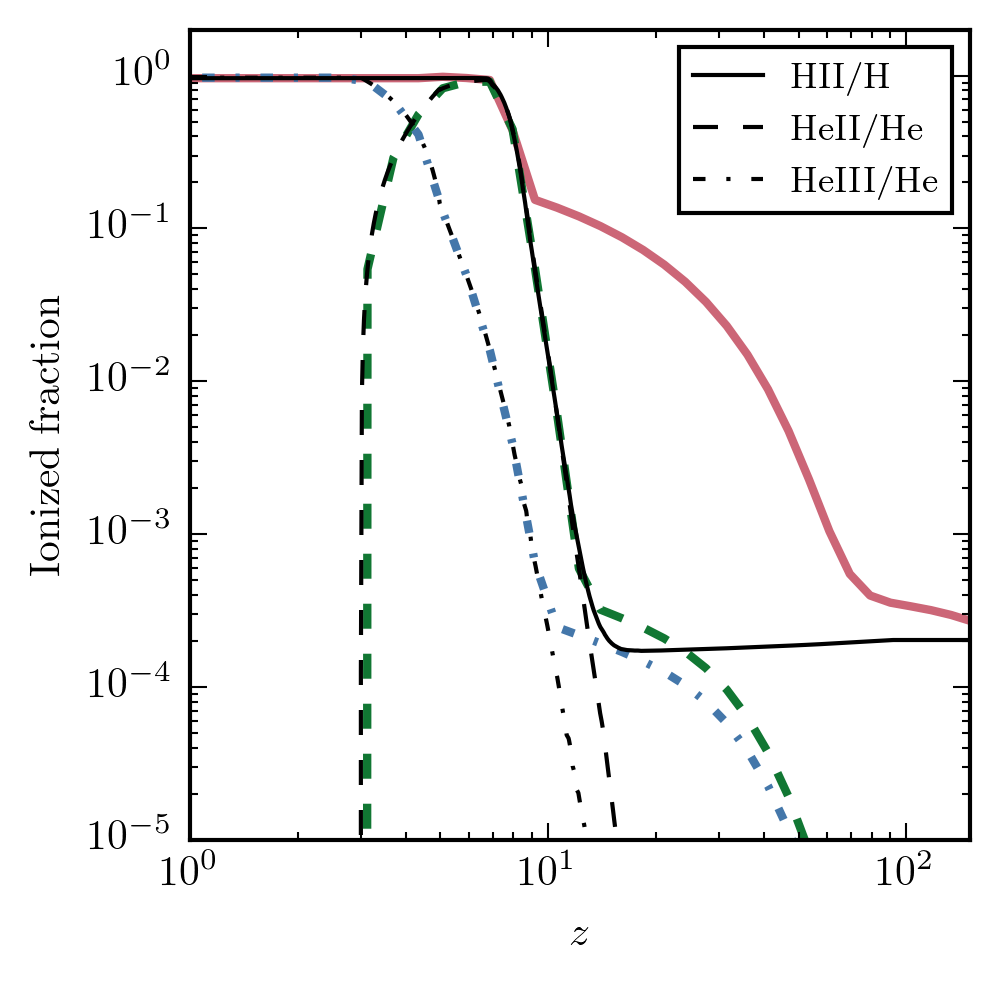

In [16]:
predicted_rhist[z_list<5,0] = np.interp(z_list, z_list_model, x_HII_list)[z_list<5]
predicted_rhist[z_list<5,1] = np.interp(z_list, z_list_model, x_HeII_list)[z_list<5]
predicted_rhist[z_list<5,2] = np.interp(z_list, z_list_model, x_HeIII_list)[z_list<5]
predicted_rhist[:,3] = np.interp(z_list, z_list_model, x_HII_list)
predicted_rhist[:,4] = np.interp(z_list, z_list_model, x_HeII_list)
predicted_rhist[:,5] = np.interp(z_list, z_list_model, x_HeIII_list)

plt.plot(z_list, predicted_rhist[:,0])
plt.plot(z_list, predicted_rhist[:,1],'--')
plt.plot(z_list, predicted_rhist[:,2],'-.')

tau_original = cp.cr.integrate_optical_depth(predicted_rhist[:,3], predicted_rhist[:,4]+2.0*predicted_rhist[:,5], z_list, **cp.fidcosmo)[-1]
tau_mod = cp.cr.integrate_optical_depth(predicted_rhist[:,0], predicted_rhist[:,1]+2.0*predicted_rhist[:,2], z_list, **cp.fidcosmo)[-1]
print tau_mod-tau_original

# print predicted_rhist
plt.plot(z_list_model, x_HII_list,'-k',lw=1, label=r'$\mathrm{HII/H}$')
plt.plot(z_list_model, x_HeII_list,'--k',lw=1,label=r'$\mathrm{HeII/He}$')
plt.plot(z_list_model, x_HeIII_list,'-.k',lw=1,label=r'$\mathrm{HeIII/He}$')

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-5, 2e0])
plt.xlabel('$z$')
plt.ylabel(r'$\mathrm{Ionized\;fraction}$')
plt.legend()
# plt.ylim([1e-4,1e-3])
plt.xlim([1,150])
plt.savefig('rhist.pdf')

In [17]:
def tau_diff(mx, sigmav, channel):
    z_list, predicted_rhist, dumb = evolve_phot(mx, sigmav, channel)
    predicted_rhist[z_list<5,0] = np.interp(z_list, z_list_model, x_HII_list)[z_list<5]
    predicted_rhist[z_list<5,1] = np.interp(z_list, z_list_model, x_HeII_list)[z_list<5]
    predicted_rhist[z_list<5,2] = np.interp(z_list, z_list_model, x_HeIII_list)[z_list<5]
    predicted_rhist[:,3] = np.interp(z_list, z_list_model, x_HII_list)
    predicted_rhist[:,4] = np.interp(z_list, z_list_model, x_HeII_list)
    predicted_rhist[:,5] = np.interp(z_list, z_list_model, x_HeIII_list)
    tau_original = cp.cr.integrate_optical_depth(predicted_rhist[:,3], predicted_rhist[:,4]+2.0*predicted_rhist[:,5], z_list, **cp.fidcosmo)[-1]
    tau_mod = cp.cr.integrate_optical_depth(predicted_rhist[:,0], predicted_rhist[:,1]+2.0*predicted_rhist[:,2], z_list, **cp.fidcosmo)[-1]
    return tau_mod-tau_original

In [18]:
tau_diff(5, 1e-25, 'b')

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: divide by zero encountered in power
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:68: RuntimeWarning: overflow encountered in exp


3.3506401264732366e-05

In [19]:
mx_list = np.sort(list(set(dm_data_pos['mDM'])))[::4]
sigmav_list = np.logspace(-28, -23, 10)
tau_map = np.zeros([len(mx_list), len(sigmav_list)])

In [20]:
channel = 'e'
for i in range(len(mx_list))[::-1]:
    print i
    for j in range(len(sigmav_list)):
        tau_map[i,j]=tau_diff(mx_list[i], sigmav_list[j], channel)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: divide by zero encountered in power
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:68: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:138: RuntimeWarning: invalid value encountered in double_scalars


15
14
13
12
11
10
9
8
7
6
5
4
3
2
1

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:110: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:111: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:112: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:114: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:145: RuntimeWarning: invalid value encountered in double_scalars



0


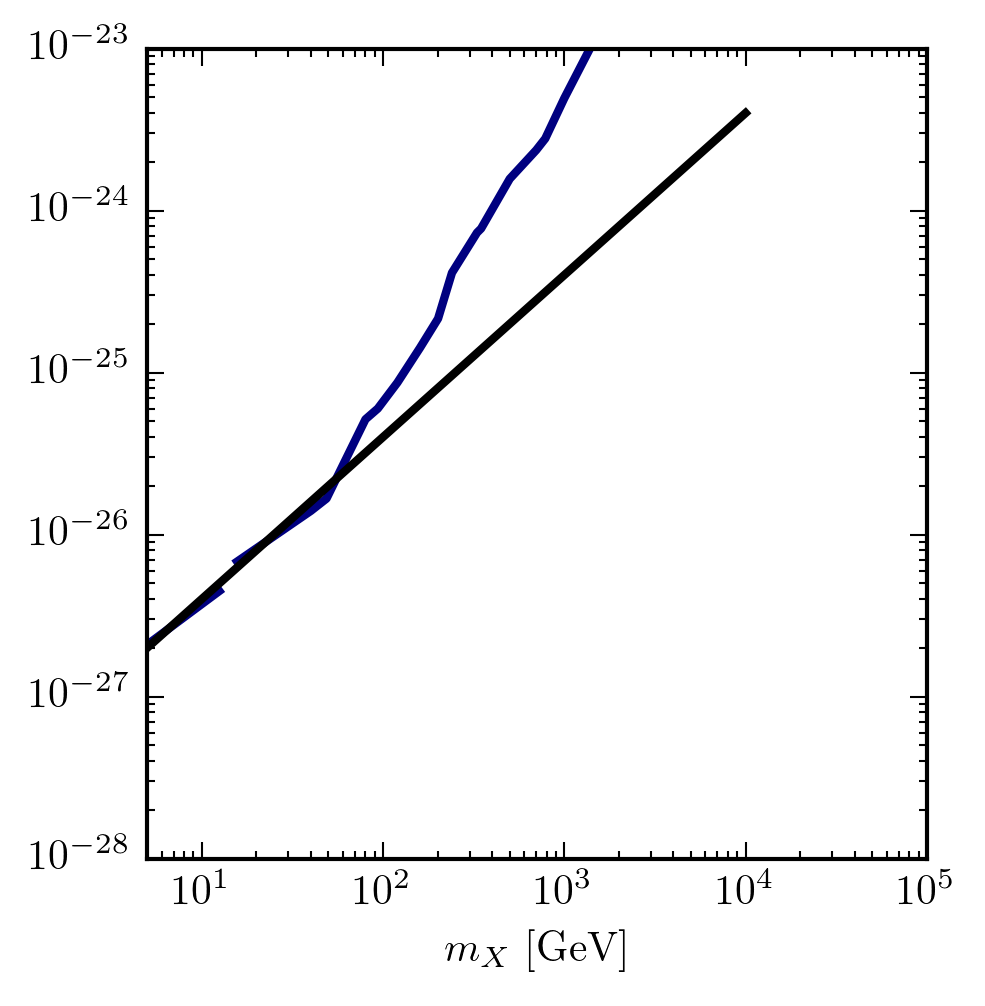

In [21]:
from matplotlib.colors import LogNorm

# plt.contourf(mx_list, sigmav_list, tau_map.T, levels=np.logspace(-5,-1,9), interpolation='nearest', norm=LogNorm(),cmap='Blues')
# plt.colorbar()
plt.contour(mx_list, sigmav_list, tau_map.T, levels=[0.012], interpolation='nearest', norm=LogNorm())
plt.plot([0.5, 1e4], [2e-28, 4e-24], 'k')
plt.xlim([5, 1e5])
plt.xlabel(r'$m_X\;\mathrm{[GeV]}$')
plt.xscale('log')
plt.yscale('log')

![Plank dm](http://2.bp.blogspot.com/-Y9UO7uQOE68/VHzDeWlgV2I/AAAAAAAABgk/FtQ8qd8HeNo/s1600/Planck_DMlimits.png)

In [ ]:
temp=z_list.copy()*0
for ii in range(len(z_list)-1):
    print ii
    # time step
    dt = age_list[ii+1]-age_list[ii]
    tau = dt
    print 'Time step [yrs]:', tau/3.14e7, temp[ii]
    # current redshift
    z = 0.5 * (z_list[ii+1] + z_list[ii])
    temp[ii+1] = temp[ii] + \
                 (boost[ii] * (1.0+z)**6 * n_dm**2 * sigmav * mx*1e9 * tau / 13.6)/n_b/(1+z)**3

In [ ]:
plt.plot(z_list, temp)
plt.yscale('log')
plt.xscale('log')
# plt.ylim([1e-5, 2e0])
# plt.ylim([1e-4,1e-3])
plt.xlim([1,300])

In [ ]:
np.sort(list(set(dm_data['mDM'])))

In [ ]:
channel='b'

params = {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.24, 'cosmo': cosmo, 'subhalos': True}
tau_map_opt = np.zeros([len(mx_list), len(sigmav_list)])
for i in range(len(mx_list))[::-1]:
    print i,
    for j in range(len(sigmav_list)):
        tau_map_opt[i,j]=tau_diff(mx_list[i], sigmav_list[j], channel)

params = {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}
tau_map_real = np.zeros([len(mx_list), len(sigmav_list)])
for i in range(len(mx_list))[::-1]:
    print i,
    for j in range(len(sigmav_list)):
        tau_map_real[i,j]=tau_diff(mx_list[i], sigmav_list[j], channel)

params = {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.08, 'cosmo': cosmo, 'subhalos': False}
tau_map_pes = np.zeros([len(mx_list), len(sigmav_list)])
for i in range(len(mx_list))[::-1]:
    print i,
    for j in range(len(sigmav_list)):
        tau_map_pes[i,j]=tau_diff(mx_list[i], sigmav_list[j], channel)

In [ ]:
import matplotlib as mpl
colors = mpl.rcParams['axes.color_cycle']

plt.plot([0.5, 1e4], np.array([2e-28, 4e-24])/0.4, ':k', label=r'$\mathrm{Recombination}\;(f=0.4)$')

plt.contour(mx_list, sigmav_list, tau_map_opt.T, 
            colors=colors[0],levels=[0.012,0.001], linestyles=['-.','-.','-.'], 
            linewidths=[2,0.5,1],# interpolation='nearest', 
            norm=LogNorm())
plt.plot([1],[1], '-.', color=colors[0], label=r'$\mathrm{High}$')

plt.contour(mx_list, sigmav_list, tau_map_real.T, 
            colors=colors[1],levels=[0.012,0.001], linestyles=['-','-','-'], 
            linewidths=[2,0.5,1],# interpolation='nearest', 
            norm=LogNorm())
plt.plot([1],[1], '-', color=colors[1], label=r'$\mathrm{Medium}$')

plt.contour(mx_list, sigmav_list, tau_map_pes.T, 
            colors=colors[2],levels=[0.012,0.001], linestyles=['--','--','--'], 
            linewidths=[2,0.5,1],# interpolation='nearest', 
            norm=LogNorm())
plt.plot([1],[1], '--', color=colors[2],label=r'$\mathrm{Low}$')

plt.xscale('log')
plt.yscale('log')
plt.xlim([5, 5e4])
plt.ylim([1e-28, 1e-23])
fixlogax(plt.gca())
plt.xlabel(r'$m_X\;\mathrm{[GeV]}$')
plt.ylabel(r'$\langle \sigma v \rangle \; \mathrm{[cm^3/s]}$')
plt.text(10,3e-24,r'$b\bar{b}\;\mathrm{channel}$')
plt.legend(loc=4)
plt.savefig('bb.pdf')
plt.savefig('bb.png', dpi=300)

In [ ]:
channel='e'

params = {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
tau_map_opt = np.zeros([len(mx_list), len(sigmav_list)])
for i in range(len(mx_list))[::-1]:
    print i,
    for j in range(len(sigmav_list)):
        tau_map_opt[i,j]=tau_diff(mx_list[i], sigmav_list[j], channel)

params = {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
tau_map_real = np.zeros([len(mx_list), len(sigmav_list)])
for i in range(len(mx_list))[::-1]:
    print i,
    for j in range(len(sigmav_list)):
        tau_map_real[i,j]=tau_diff(mx_list[i], sigmav_list[j], channel)

params = {'logMcrit': -3, 'Ishiyama': False, 'c_scatter': 0.10, 'cosmo': cosmo, 'subhalos': False}
tau_map_pes = np.zeros([len(mx_list), len(sigmav_list)])
for i in range(len(mx_list))[::-1]:
    print i,
    for j in range(len(sigmav_list)):
        tau_map_pes[i,j]=tau_diff(mx_list[i], sigmav_list[j], channel)

In [ ]:
import matplotlib as mpl
colors = mpl.rcParams['axes.color_cycle']

plt.plot([0.5, 1e4], np.array([2e-28, 4e-24])/1.0, ':k', label=r'$\mathrm{Recombination}\;(f=1.0)$')

plt.contour(mx_list, sigmav_list, tau_map_opt.T, 
            colors=colors[0],levels=[0.012,0.001], linestyles=['-.','-.','-.'], 
            linewidths=[2,0.5,1],# interpolation='nearest', 
            norm=LogNorm())
plt.plot([1],[1], '-.', color=colors[0], label=r'$\mathrm{High}$')

plt.contour(mx_list, sigmav_list, tau_map_real.T, 
            colors=colors[1],levels=[0.012,0.001], linestyles=['-','-','-'], 
            linewidths=[2,0.5,1],# interpolation='nearest', 
            norm=LogNorm())
plt.plot([1],[1], '-', color=colors[1], label=r'$\mathrm{Medium}$')

plt.contour(mx_list, sigmav_list, tau_map_pes.T, 
            colors=colors[2],levels=[0.012,0.001], linestyles=['--','--','--'], 
            linewidths=[2,0.5,1],# interpolation='nearest', 
            norm=LogNorm())
plt.plot([1],[1], '--', color=colors[2],label=r'$\mathrm{Low}$')

plt.xscale('log')
plt.yscale('log')
plt.xlim([5, 5e4])
plt.ylim([1e-28, 1e-23])
fixlogax(plt.gca())
plt.xlabel(r'$m_X\;\mathrm{[GeV]}$')
plt.ylabel(r'$\langle \sigma v \rangle \; \mathrm{[cm^3/s]}$')
plt.text(10,3e-24,r'$e^+e^-\;\mathrm{channel}$')
plt.legend(loc=4)
plt.savefig('e.pdf')
plt.savefig('e.png', dpi=300)

In [ ]:
channels=['b', 'e', 'Mu', 'Tau', 'b', 'q', 'c']
for channel in channels:
    print channel
    params = {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
    tau_map_opt = np.zeros([len(mx_list), len(sigmav_list)])
    for i in range(len(mx_list))[::-1]:
        print i,
        for j in range(len(sigmav_list)):
            tau_map_opt[i,j]=tau_diff(mx_list[i], sigmav_list[j], channel)

    params = {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
    tau_map_real = np.zeros([len(mx_list), len(sigmav_list)])
    for i in range(len(mx_list))[::-1]:
        print i,
        for j in range(len(sigmav_list)):
            tau_map_real[i,j]=tau_diff(mx_list[i], sigmav_list[j], channel)

    params = {'logMcrit': -3, 'Ishiyama': False, 'c_scatter': 0.10, 'cosmo': cosmo, 'subhalos': False}
    tau_map_pes = np.zeros([len(mx_list), len(sigmav_list)])
    for i in range(len(mx_list))[::-1]:
        print i,
        for j in range(len(sigmav_list)):
            tau_map_pes[i,j]=tau_diff(mx_list[i], sigmav_list[j], channel)
    
    np.savez(channel+'_precalc.npz', tau_map_opt=tau_map_opt, tau_map_real=tau_map_real, tau_map_pes=tau_map_pes, mx_list=mx_list, sigmav_list=sigmav_list)


In [ ]:
channels=['e', 'Mu', 'Tau', 'b', 'q', 'c']
names=[r'$e^+e^-$', 
      r'$\mu^+\mu^-$', 
      r'$\tau^+\tau^-$', 
      r'$b\bar{b}$', 
      r'$q\bar{q}$', 
      r'$c\bar{c}$', 
      ]
factors = ['1.0', '0.3', '0.3', '0.4']


import matplotlib as mpl
colors = mpl.rcParams['axes.color_cycle']
for i in range(len(factors)):
    channel = channels[i]
    data = np.load(channel+'_precalc.npz')
    tau_map_opt = data['tau_map_opt']
    tau_map_real = data['tau_map_real']
    tau_map_pes = data['tau_map_pes']
    mx_list =  data['mx_list']
    sigmav_list =  data['sigmav_list']
    plt.clf()    
    plt.plot([0.5, 1e4], np.array([2e-28, 4e-24])/float(factors[i]), ':k', label=r'$\mathrm{Recombination}\;(f='+factors[i]+')$')

    plt.contour(mx_list, sigmav_list, tau_map_opt.T, 
                colors=colors[0],levels=[0.012,0.001], linestyles=['-.','-.','-.'], 
                linewidths=[2,0.5,1],# interpolation='nearest', 
                norm=LogNorm())
    plt.plot([1],[1], '-.', color=colors[0], label=r'$\mathrm{High}$')

    plt.contour(mx_list, sigmav_list, tau_map_real.T, 
                colors=colors[1],levels=[0.012,0.001], linestyles=['-','-','-'], 
                linewidths=[2,0.5,1],# interpolation='nearest', 
                norm=LogNorm())
    plt.plot([1],[1], '-', color=colors[1], label=r'$\mathrm{Medium}$')

    plt.contour(mx_list, sigmav_list, tau_map_pes.T, 
                colors=colors[2],levels=[0.012,0.001], linestyles=['--','--','--'], 
                linewidths=[2,0.5,1],# interpolation='nearest', 
                norm=LogNorm())
    plt.plot([1],[1], '--', color=colors[2],label=r'$\mathrm{Low}$')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([5, 5e4])
    plt.ylim([1e-28, 1e-23])
    fixlogax(plt.gca())
    plt.xlabel(r'$m_X\;\mathrm{[GeV]}$')
    plt.ylabel(r'$\langle \sigma v \rangle \; \mathrm{[cm^3/s]}$')
    plt.text(10,3e-24,names[i])#r'$e^+e^-\;\mathrm{channel}$')
    plt.legend(loc=4)
    plt.savefig(channel+'.pdf')
    plt.savefig(channel+'.png', dpi=300)